In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/SOLO')
sys.path.append(str(base))

Mounted at /content/drive


In [2]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/SOLO")
os.listdir()

['config.py',
 'mmdetection',
 'colab_installed.txt',
 'pretrained',
 '__pycache__',
 'loss.py',
 'dataset.py',
 'SOLO.ipynb',
 'models.py',
 'utils.py',
 'Test.ipynb']

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

from PIL import Image

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data

import tqdm
from torchsummary import summary
import seaborn as sns

In [4]:
from models import Autoencoder
from models import AutoencoderLN
from models import FixedAutoencoder
from loss import Loss
from loss import DiceLoss
from loss import FocalLoss
from dataset import CocoDataset
from utils import *

In [ ]:
#!wget http://images.cocodataset.org/zips/train2017.zip
#!wget http://images.cocodataset.org/zips/val2017.zip
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
#!unzip 'train2017.zip'
#!unzip 'val2017.zip'
#!unzip 'annotations_trainval2017.zip'

#!rm 'train2017.zip'
#!rm 'val2017.zip'
#!rm 'annotations_trainval2017.zip'

##Prepare data

In [5]:
transform = transforms.Compose(
      [transforms.ToPILImage(),
       transforms.Scale(256),
       transforms.CenterCrop(224),
       transforms.ToTensor()]
       #transforms.Normalize(mean=[0.5],
                                  #std=[0.5])]
  )

val_loader = get_loader(root='mmdetection/val2017', 
                        json='mmdetection/annotations/instances_val2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


loading annotations into memory...
Done (t=2.62s)
creating index...
index created!


In [6]:
train_loader = get_loader(root='mmdetection/train2017', 
                        json='mmdetection/annotations/instances_train2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)

loading annotations into memory...
Done (t=19.87s)
creating index...
index created!


##Try Neptune

Результаты [тут](https://ui.neptune.ai/a.chubcheva/Instance-segmentation/experiments?viewId=standard-view)

In [7]:
!pip install neptune-client

     |████████████████████████████████| 112kB 8.5MB/s 
     |████████████████████████████████| 829kB 10.9MB/s 
     |████████████████████████████████| 204kB 23.4MB/s 
     |████████████████████████████████| 163kB 22.7MB/s 
     |████████████████████████████████| 133kB 27.7MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.132-py2.py3-none-any.whl size=166223 sha256=0d9fa3eb50071028988f1fb0fb90508d20e8c4a6fdab286bce91d1ff9e3bb40c
  Stored in directory: /root/.cache/pip/wheels/ef/17/bc/2f8eef68e5adb68415d3634a6c70185860f4461b00c1c6a37b
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=c2c73e54f86fed10d5b4d6f8fa6df33d93f4d98a26f4bf4750ad624f49761169
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp36-non

In [8]:
import neptune
from config import API_TOKEN
neptune.init('a.chubcheva/Instance-segmentation', api_token=API_TOKEN)

Project(a.chubcheva/Instance-segmentation)

##Autoencoder

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###Little one

In [ ]:
class NaiveAutoencoder(nn.Module):
  def __init__(self):
        super(NaiveAutoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=0),
            nn.Sigmoid()
        )

    
  def forward(self, x):
        # encode
        x = self.encoder(x)

        # decode
        x = self.decoder(x)
        return x
  


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NaiveAutoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = Loss(alpha=10, gamma=3)
#criterion = nn.MSELoss()
num_epochs = 5

In [ ]:
naive_autoencoder, loss_history_ae = train_autoencoder(model,criterion, opt, val_loader, num_epochs)


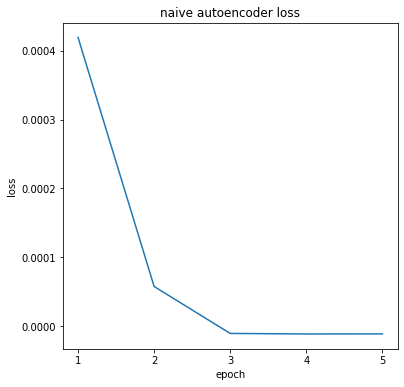

In [ ]:
plt.figure(figsize=(6,6))
plt.title('naive autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

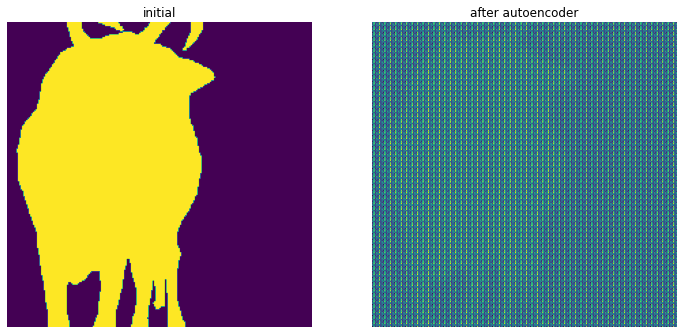

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
#index = np.random.randint(len(val_loader.dataset))
index = 12972
img = val_loader.dataset[index]
plt.title('initial')
plt.axis('off')
plt.imshow(img.squeeze().numpy());

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = naive_autoencoder(img.unsqueeze(0))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach().numpy().squeeze());

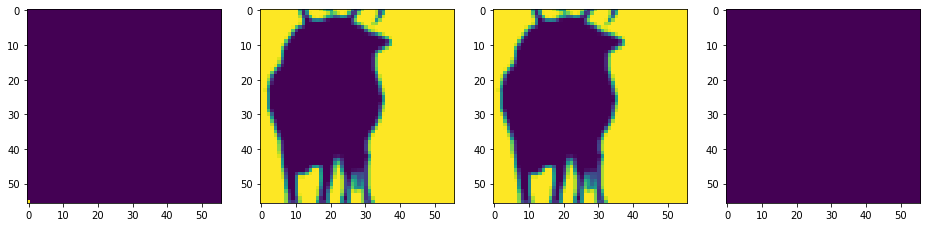

In [ ]:
hid = naive_autoencoder.encoder(img.unsqueeze(0))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(1, 4, 1)
plt.imshow(hid[:,0,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 2)
plt.imshow(hid[:,1,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 3)
plt.imshow(hid[:,2,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 4)
plt.imshow(hid[:,3,:,:].detach().cpu().squeeze().numpy());

###Bigger one

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from models import Autoencoder

In [ ]:
model = Autoencoder().to(device)
summary(model, (1, 256, 256))

RuntimeError: ignored

In [ ]:
model = Autoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=2, gamma=5)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-37



  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [1/5], loss:-1.8229




100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [2/5], loss:-1.6108




100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [3/5], loss:-1.7401




100%|██████████| 200/200 [00:52<00:00,  3.80it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [4/5], loss:-1.4881




100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


epoch [5/5], loss:-1.6219



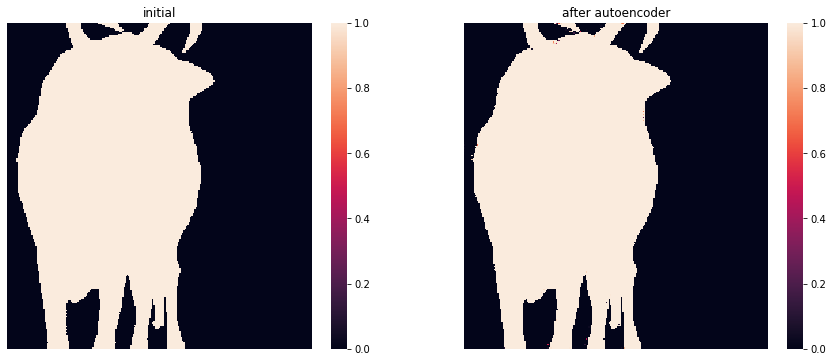

In [ ]:
neptune.create_experiment(name='conv1')
conv_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(conv_autoencoder, val_loader, neptune=neptune)
neptune.stop()

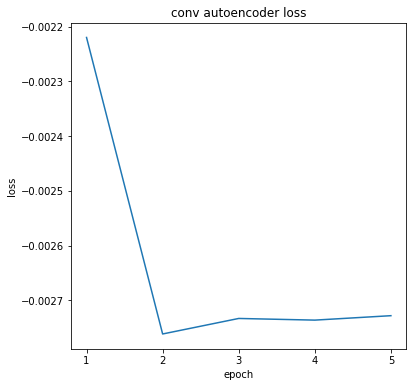

In [ ]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(conv_autoencoder.state_dict(), "conv_autoencoder.pth")

In [ ]:
autoencoder1 = Autoencoder().to(device)
autoencoder1.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder1.eval()

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec20): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec21): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec22): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm): Sigmoid()
)

###Layer norm

In [ ]:
from models import AutoencoderLN

In [ ]:
model = AutoencoderLN().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
         LeakyReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 32, 128, 112]          18,464
         LeakyReLU-4         [-1, 32, 128, 112]               0
            Conv2d-5            [-1, 8, 64, 56]           2,312
         LeakyReLU-6            [-1, 8, 64, 56]               0
            Conv2d-7            [-1, 1, 32, 28]              73
         LeakyReLU-8            [-1, 1, 32, 28]               0
   ConvTranspose2d-9            [-1, 8, 32, 28]              80
        LeakyReLU-10            [-1, 8, 32, 28]               0
  ConvTranspose2d-11           [-1, 32, 64, 56]           2,336
        LeakyReLU-12           [-1, 32, 64, 56]               0
  ConvTranspose2d-13         [-1, 64, 128, 112]          18,496
        LeakyReLU-14         [-1, 64, 1

In [ ]:
model = AutoencoderLN().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=3, gamma=3)
num_epochs = 3

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-40





  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



  0%|          | 1/200 [00:00<02:29,  1.33it/s]


  1%|          | 2/200 [00:01<02:07,  1.56it/s]


  2%|▏         | 3/200 [00:01<01:51,  1.77it/s]


  2%|▏         | 4/200 [00:01<01:42,  1.92it/s]


  2%|▎         | 5/200 [00:02<01:37,  1.99it/s]


  3%|▎         | 6/200 [00:02<01:36,  2.00it/s]


  4%|▎         | 7/200 [00:03<01:34,  2.05it/s]


  4%|▍         | 8/200 [00:03<01:30,  2.13it/s]


  4%|▍         | 9/200 [00:04<01:25,  2.25it/s]


  5%|▌         | 10/200 [00:04<01:27,  2.17it/s]


  6%|▌         | 11/200 [00:05<01:22,  2.28it/s]


  6%|▌         | 12/200 [00:05<01:23,  2.25it/s]


  6%|▋         | 13/200 [00:06<01:26,  2.17it/s]


  7%|▋         | 14/200 [00:06<01:30,  2.06it/s]


  8%|▊         | 15/200 [00:06<01:24,  2.18it/s]

epoch [1/3], loss:-2.4697






  0%|          | 1/200 [00:00<01:37,  2.03it/s]


  1%|          | 2/200 [00:00<01:37,  2.03it/s]


  2%|▏         | 3/200 [00:01<01:32,  2.12it/s]


  2%|▏         | 4/200 [00:01<01:32,  2.13it/s]


  2%|▎         | 5/200 [00:02<01:31,  2.13it/s]


  3%|▎         | 6/200 [00:02<01:32,  2.09it/s]


  4%|▎         | 7/200 [00:03<01:32,  2.09it/s]


  4%|▍         | 8/200 [00:03<01:28,  2.16it/s]


  4%|▍         | 9/200 [00:04<01:26,  2.22it/s]


  5%|▌         | 10/200 [00:04<01:22,  2.31it/s]


  6%|▌         | 11/200 [00:05<01:23,  2.26it/s]


  6%|▌         | 12/200 [00:05<01:26,  2.18it/s]


  6%|▋         | 13/200 [00:06<01:30,  2.08it/s]


  7%|▋         | 14/200 [00:06<01:24,  2.20it/s]


  8%|▊         | 15/200 [00:06<01:24,  2.19it/s]


  8%|▊         | 16/200 [00:07<01:24,  2.18it/s]


  8%|▊         | 17/200 [00:07<01:24,  2.17it/s]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]


 10%|▉         | 19/200 [00:08<01:27,  2.08it/s]


 10%|█         | 20/200 [00:09<01:27,

epoch [2/3], loss:-2.4273






  0%|          | 1/200 [00:00<01:38,  2.02it/s]


  1%|          | 2/200 [00:00<01:36,  2.06it/s]


  2%|▏         | 3/200 [00:01<01:34,  2.08it/s]


  2%|▏         | 4/200 [00:01<01:30,  2.17it/s]


  2%|▎         | 5/200 [00:02<01:31,  2.12it/s]


  3%|▎         | 6/200 [00:02<01:26,  2.24it/s]


  4%|▎         | 7/200 [00:03<01:31,  2.12it/s]


  4%|▍         | 8/200 [00:03<01:26,  2.23it/s]


  4%|▍         | 9/200 [00:04<01:30,  2.11it/s]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]


  6%|▌         | 11/200 [00:05<01:25,  2.21it/s]


  6%|▌         | 12/200 [00:05<01:23,  2.26it/s]


  6%|▋         | 13/200 [00:05<01:25,  2.18it/s]


  7%|▋         | 14/200 [00:06<01:25,  2.18it/s]


  8%|▊         | 15/200 [00:06<01:27,  2.12it/s]


  8%|▊         | 16/200 [00:07<01:26,  2.13it/s]


  8%|▊         | 17/200 [00:07<01:27,  2.10it/s]


  9%|▉         | 18/200 [00:08<01:23,  2.18it/s]


 10%|▉         | 19/200 [00:08<01:24,  2.13it/s]


 10%|█         | 20/200 [00:09<01:25,

epoch [3/3], loss:-1.7967



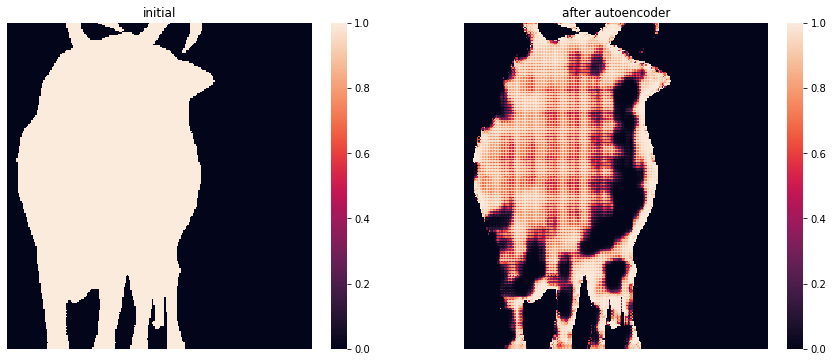

In [ ]:
neptune.create_experiment(name='ln1')
ln_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(ln_autoencoder, val_loader, neptune=neptune)
neptune.stop()

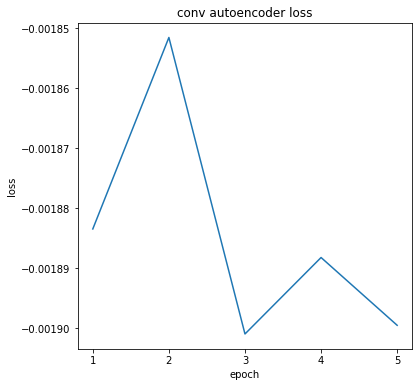

In [ ]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(ln_autoencoder.state_dict(), "ln_autoencoder.pth")

### Fixed size of hidden representation

In [ ]:
model = FixedAutoencoder().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
              ReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 64, 128, 112]          36,928
              ReLU-4         [-1, 64, 128, 112]               0
            Conv2d-5           [-1, 32, 64, 56]          18,464
              ReLU-6           [-1, 32, 64, 56]               0
            Conv2d-7           [-1, 16, 32, 28]           4,624
              ReLU-8           [-1, 16, 32, 28]               0
 AdaptiveMaxPool2d-9  [[-1, 16, 1, 1], [-1, 16, 1, 1]]               0
  ConvTranspose2d-10           [-1, 16, 64, 56]           2,320
             ReLU-11           [-1, 16, 64, 56]               0
  ConvTranspose2d-12           [-1, 32, 64, 56]           4,640
             ReLU-13           [-1, 32, 64, 56]               0
  ConvTranspose2d-14           [

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=3, gamma=3)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-42


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/200 [00:00<00:33,  5.86it/s]

epoch [1/5], loss:-2.6249



  0%|          | 1/200 [00:00<00:31,  6.32it/s]

epoch [2/5], loss:-2.2500



  0%|          | 1/200 [00:00<00:29,  6.83it/s]

epoch [3/5], loss:-2.6250



  0%|          | 1/200 [00:00<00:30,  6.43it/s]

epoch [4/5], loss:-2.6249



100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


epoch [5/5], loss:-2.4375



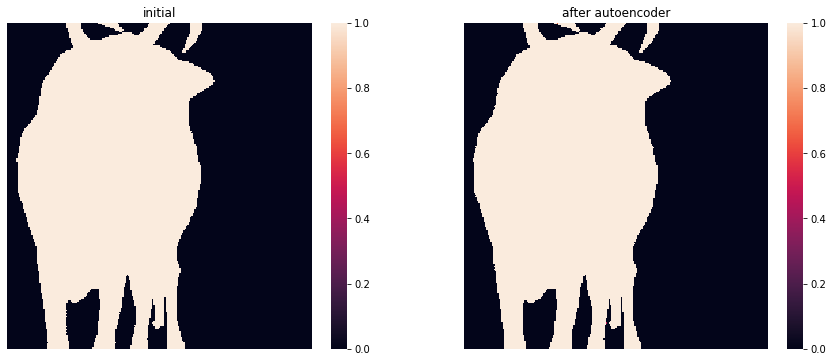

In [ ]:
neptune.create_experiment(name='fixed')
fix_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(fix_autoencoder, val_loader, neptune=neptune)
neptune.stop()

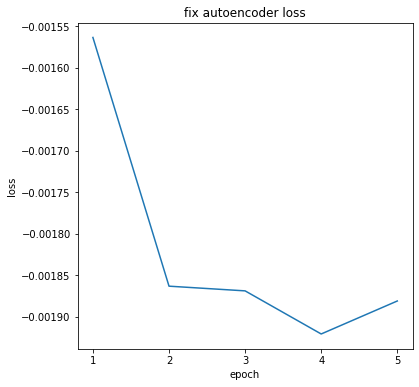

In [ ]:
plt.figure(figsize=(6,6))
plt.title('fix autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(fix_autoencoder.state_dict(), "fix_autoencoder.pth")

### VAE-GAN

In [9]:
class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.mu = nn.Linear(128, 128)
        self.log_sigma = nn.Linear(128, 128)
        self.flatten = nn.Flatten()
        self.reshape = None

        self.encoder = nn.Sequential(*[
            nn.Conv2d(1, 8, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(8, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(16, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ReLU()
            #nn.Flatten()
        ])

    def forward(self, x):
        # encode
        x = self.encoder(x)
        #size0 = x.shape[1:]
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        mu_values = self.mu(x)
        log_sigma_values = self.log_sigma(x)
        return mu_values, log_sigma_values



class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(*[
            RestoreShape([32, 2, 2]),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=5, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=5, stride=3, padding=0),
            nn.Sigmoid()
        ])
    def forward(self, x):
        return self.decoder(x)

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(8, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(16, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        #img_flat = img.view(img.size(0), -1)
        validity = self.model(img)

        return validity

In [24]:
class VAE_GAN(nn.Module):
  def __init__(self):
        super(VAE_GAN, self).__init__()

        self.reshape = RestoreShape([32, 2, 2])

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator()
        

  def reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = mu_values + torch.exp(log_sigma_values) * sample
        return latent_sample
    

  def forward(self, x):
        # encode
        mu_values, log_sigma_values = self.encoder(x)
        size0 = x.shape[1:]
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)

        # reparametrize
        raw_sample = torch.randn_like(mu_values)
        x = self.reparametrize(raw_sample, mu_values, log_sigma_values)
        #x = mu_values
        #self.reshape = RestoreShape(size0)
        #hid_repr = self.reshape(x)

        # decode
        x = self.decoder(x)
        #print(x.shape)
        return x

In [25]:
model = VAE_GAN().to(torch.device('cuda'))
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 74, 74]             208
       BatchNorm2d-2            [-1, 8, 74, 74]              16
              ReLU-3            [-1, 8, 74, 74]               0
            Conv2d-4           [-1, 16, 24, 24]           3,216
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7             [-1, 32, 8, 8]          12,832
       BatchNorm2d-8             [-1, 32, 8, 8]              64
              ReLU-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 2, 2]          25,632
      BatchNorm2d-11             [-1, 32, 2, 2]              64
             ReLU-12             [-1, 32, 2, 2]               0
           Linear-13                  [-1, 128]          16,512
           Linear-14                  [

In [ ]:
model = Discriminator().to(torch.device('cuda'))
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 74, 74]             208
              ReLU-2            [-1, 8, 74, 74]               0
            Conv2d-3           [-1, 16, 24, 24]           3,216
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 2, 2]          25,632
              ReLU-8             [-1, 32, 2, 2]               0
           Flatten-9                  [-1, 128]               0
           Linear-10                   [-1, 32]           4,128
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 1]              33
          Sigmoid-13                    [-1, 1]               0
Total params: 46,049
Trainable params: 

In [ ]:
def train_batch(inputs,
                model,
                g_criterion, d_criterion, 
                g_optimizer, e_optimizer, d_optimizer, 
                diff_size=False,
                hid_size=128):
        model.train(True)
        
        #train discriminator
        outputs = model(inputs)
        z_rand = Variable(torch.randn(len(x), hid_size).to(device), requires_grad=True)
        outputs_rand = model.decoder(z_p)

        valid = Variable(torch.Tensor(inputs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(inputs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
            
        fake_loss = d_criterion(model.discriminator(outputs), fake)
        fake_loss += d_criterion(model.discriminator(outputs_rand), fake)
        real_loss = d_criterion(model.discriminator(inputs), valid)
        loss_D = real_loss + fake_loss / 2

        d_optimizer.zero_grad()
        loss_D.backward()
        d_optimizer.step()

        # train generator
        g_optimizer.zero_grad()
        outputs = generator(inputs)
            #print(inputs.shape, outputs.shape)
        g_loss = g_criterion(outputs, inputs)
        gd_loss = d_criterion
        g_loss.backward(retain_graph = True)
        g_optimizer.step()

In [ ]:
def train_vae_gan(generator, discriminator,
                  g_criterion, d_criterion, 
                  g_optimizer, d_optimizer, 
                  dataloader, num_epochs, epoch_len=100, batch_size=16, neptune=None, diff_size=False):
  
  best_model_wts = deepcopy(generator.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    g_loss = 0
    d_loss = 0
    for i in tqdm.trange(epoch_len):
        
        #inputs = next(iter(dataloader))

        # variable image size
        if diff_size:
            k = np.random.randint(15, 20)
            inputs = F.interpolate(inputs, (k*16, k*16))
        #inputs = Variable(inputs.to(device))

        # train generator
        generator.train(True)
        discriminator.train(False)
        for i in range(20):
            inputs = next(iter(dataloader))
            inputs = Variable(inputs.to(device))
            g_optimizer.zero_grad()
            outputs = generator(inputs)
            #print(inputs.shape, outputs.shape)
            loss = g_criterion(outputs, inputs)
            if neptune is not None:
              neptune.log_metric('loss', loss)
            g_loss += loss.item()
            loss.backward(retain_graph = True)
            g_optimizer.step()

        # train dicsriminator
        generator.train(False)
        discriminator.train(True)
        for i in range(20):
            inputs = next(iter(dataloader))
            inputs = Variable(inputs.to(device))
            outputs = generator(inputs)
            d_optimizer.zero_grad()
            valid = Variable(torch.Tensor(inputs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
            fake = Variable(torch.Tensor(inputs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
            
            fake_loss = d_criterion(discriminator(outputs), fake)
            real_loss = d_criterion(discriminator(inputs), valid)
            adv_loss = (real_loss + fake_loss) / 2

            adv_loss.backward(retain_graph = True)
            d_optimizer.step()

            d_loss += adv_loss.item()

    g_loss /= len(dataloader.dataset)
    d_loss /= len(dataloader.dataset)
    if neptune is not None:
        neptune.log_metric('epoch_loss_generator', g_loss)
        neptune.log_metric('epoch_loss_discriminator', d_loss)
    loss_history.append(g_loss)
    if g_loss < best_loss:
        best_model_wts = deepcopy(generator.state_dict())
    print('epoch [{}/{}], gen loss:{:.4f}, discr loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item(), adv_loss.item()))

  generator.load_state_dict(best_model_wts)
  return generator, discriminator, loss_history

In [26]:
generator = VAE_GAN().to(device)
discriminator = Discriminator().to(device)
e_opt = optim.Adam(generator.encoder.parameters(), lr=1e-3)
d_opt = optim.Adam(generator.decoder.parameters(), lr=1e-3)
g_opt = optim.Adam(generator.parameters(), lr=1e-3)
criterion = nn.MSELoss()
#criterion = Loss(alpha=3, gamma=3).to(device)
num_epochs = 10
adversarial_loss = torch.nn.BCELoss().to(device)

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-75


  0%|          | 1/500 [00:00<01:03,  7.91it/s]

epoch [1/10], loss:0.0244



  0%|          | 1/500 [00:00<01:03,  7.87it/s]

epoch [2/10], loss:0.0169



  0%|          | 1/500 [00:00<00:59,  8.44it/s]

epoch [3/10], loss:0.0117



  0%|          | 1/500 [00:00<01:02,  7.99it/s]

epoch [4/10], loss:0.0153



  0%|          | 1/500 [00:00<00:57,  8.62it/s]

epoch [5/10], loss:0.0118



  0%|          | 1/500 [00:00<01:02,  8.05it/s]

epoch [6/10], loss:0.0193



  0%|          | 1/500 [00:00<01:02,  7.96it/s]

epoch [7/10], loss:0.0055



  0%|          | 1/500 [00:00<01:01,  8.17it/s]

epoch [8/10], loss:0.0066



  0%|          | 1/500 [00:00<01:10,  7.13it/s]

epoch [9/10], loss:0.0036



100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


epoch [10/10], loss:0.0083



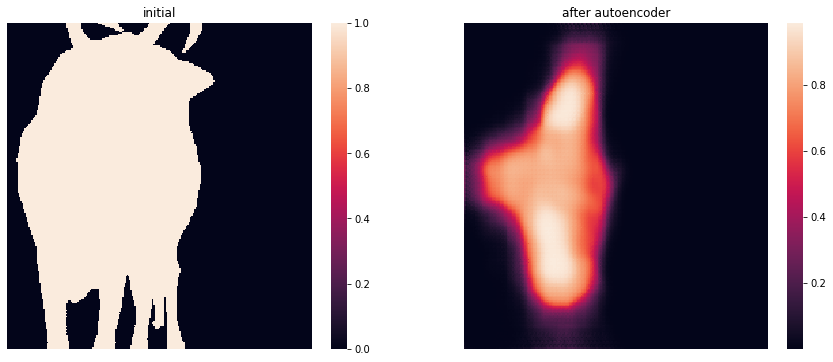

In [27]:
neptune.create_experiment(name='vae - mse')
vae, loss_history_ae = train_autoencoder(generator, 
                                                criterion,
                                                g_opt, 
                                                train_loader, num_epochs, epoch_len=500, neptune=neptune)

test_model(vae, val_loader, neptune=neptune)
neptune.stop()

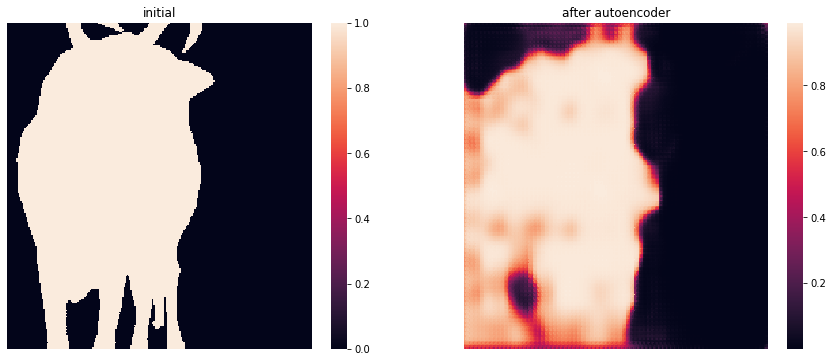

In [ ]:
test_model(vae, val_loader)